<a href="https://colab.research.google.com/github/zawuya/Dlab-Project/blob/master/telecom_sentiment_analysis_revised_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Revised Version 1.0

In [108]:
! pip install catboost
! pip install lightgbm
! pip install xgboost
! pip install scikit-optimize
! pip install category-encoders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Import dataset

In [109]:
#import useful libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re 
import os
import joblib 
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import catboost as ctb
import lightgbm as ltb
import collections
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import plot_importance
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

In [110]:
warnings.filterwarnings("ignore")

In [111]:
telecom_data=pd.read_csv("telecom_TZ_sentiment_data2.csv", dtype=str)

In [112]:
telecom_data.head()

,date,comment,platform,sentiment
0,2021-10-23 14:36:34+00:00,Chezea songesha wew https://t.co/FfnSsIkZGU,Twitter,1
1,2021-09-28 15:37:16+00:00,Tafuta hela sana ili usilalamikie mabadiliko y...,Twitter,1
2,2022-09-18 13:37:06+00:00,Hivi huu mtandao wa Tigo una tatizo au simu ya...,Twitter,-1
3,2021-04-08 18:34:13+00:00,@DaktariWaWatoto Tamtam bando ni ðŸ”¥ ila kuin...,Twitter,1
4,2022-09-24 05:03:32+00:00,@VodacomTanzania @ImranHussein84 Tatizo kifuru...,Twitter,-1


# 2. Exploratory Data Analysis

In [113]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       8789 non-null   object
 1   comment    8789 non-null   object
 2   platform   8788 non-null   object
 3   sentiment  8782 non-null   object
dtypes: object(4)
memory usage: 274.8+ KB


In [114]:
telecom_data.duplicated().sum()

11

In [115]:
telecom_data.describe()

,date,comment,platform,sentiment
count,8789,8789,8788,8782
unique,8578,8775,3,4
top,2022-01-07 16:34:48+00:00,@airtel_tanzania nawapenda sana huduma hii ya ...,Twitter,-1
freq,2,2,8786,4649


In [116]:
telecom_data.isna().sum()

date         1
comment      1
platform     2
sentiment    8
dtype: int64

In [117]:
telecom_data.dtypes

date         object
comment      object
platform     object
sentiment    object
dtype: object

In [118]:
telecom_data['sentiment'].value_counts()

-1           4649
0            3567
1             565
complains       1
Name: sentiment, dtype: int64

In [119]:
telecom_data.loc[telecom_data['sentiment'] == 'complains']

,date,comment,platform,sentiment
1698,Twitter,0,network,complains


In [120]:
telecom_data = telecom_data.drop(index=1698, axis=1).reset_index(drop=True)

In [121]:
telecom_data['sentiment'].value_counts()

-1    4649
0     3567
1      565
Name: sentiment, dtype: int64

In [122]:
telecom_data.duplicated().sum()

11

# 3. Data Processing

## 3.1 Remove duplicate

In [123]:
telecom_data.drop_duplicates(subset=['comment'], keep='first', inplace=True)

## 3.2 Remove null values

In [124]:
telecom_data.dropna(subset=['sentiment', 'comment'], inplace=True)

## check the dataset status

In [125]:
telecom_data.duplicated().sum()

0

In [126]:
telecom_data.isna().sum()

date         0
comment      0
platform     0
sentiment    0
dtype: int64

In [127]:
telecom_data.count()

date         8767
comment      8767
platform     8767
sentiment    8767
dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

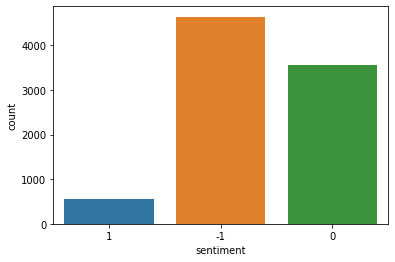

In [128]:
sns.countplot(x="sentiment", data=telecom_data)

In [129]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8767 entries, 0 to 8788
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       8767 non-null   object
 1   comment    8767 non-null   object
 2   platform   8767 non-null   object
 3   sentiment  8767 non-null   object
dtypes: object(4)
memory usage: 342.5+ KB


# 3.3 Cleaning

In [130]:
def clean_data_set(list_text):
    new_list = []
    stopwords_df = pd.read_csv("swahili_stopwords.csv", dtype=str, low_memory=False, encoding="utf-8")
    stopwords_list = list(stopwords_df['StopWords'])
    
    for x in list_text:
        x = re.sub(r'@[\w]+','', str(x)) # remove twitter handle
        x = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x)) # removes Url
        x = re.sub(r'[^\w\s]',' ', str(x))    # Remove Panctuations /?!. 
        x = x.strip()                   # Remove leading and trailing spaces
        x = re.sub(' +', ' ', x)        # Remove extra white spaces
        x = re.sub('[^A-Za-z0-9]+', ' ', x)  # Remove special characters
        x = x.lower()                   # Converts to lower case
        x = ' '.join([word for word in x.split() if word not in stopwords_list]) # Removes stopwords
        new_list.append(x)
    return new_list

In [131]:
telecom_data["clean_comment"] = clean_data_set(telecom_data.comment.to_list())

In [132]:
telecom_data[['comment', 'clean_comment']]

,comment,clean_comment
0,Chezea songesha wew https://t.co/FfnSsIkZGU,chezea songesha wew
1,Tafuta hela sana ili usilalamikie mabadiliko y...,tafuta hela usilalamikie mabadiliko vifurushi ...
2,Hivi huu mtandao wa Tigo una tatizo au simu ya...,mtandao tigo una tatizo simu siku tatu leo mam...
3,@DaktariWaWatoto Tamtam bando ni ðŸ”¥ ila kuin...,tamtam bando kuinunulia mpk tpesa
4,@VodacomTanzania @ImranHussein84 Tatizo kifuru...,tatizo kifurushi internet nw akikai awali una ...
...,...,...
8784,@LuisaUhuru Unastream kutumia mtandao gani\nÃ°...,unastream kutumia mtandao gani
8785,Sasa mnasema mmebadilisha vifurushi naomba mni...,mnasema mmebadilisha vifurushi naomba mnitajie...
8786,@George_Ambangil @Tigo_TZ Sasa kama ad ww unal...,ad ww unalalamika vo mm nan niendelee kutumia ...
8787,@mafolebaraka @Haloteltz Bora wewe mi nikitumi...,bora mi nikitumiwa pesa halopesa haiingii wala...


In [133]:
telecom_data.to_csv("clean_telecom_data.csv", index=False)

# 4 Modeling

In [134]:
clean_telecom_data = pd.read_csv("clean_telecom_data.csv")

In [135]:
path = 'models'
isExisting = os.path.exists(path)
if not isExisting:
  os.mkdir(path)

In [136]:
telecom_data[["clean_comment", 'sentiment']]

,clean_comment,sentiment
0,chezea songesha wew,1
1,tafuta hela usilalamikie mabadiliko vifurushi ...,1
2,mtandao tigo una tatizo simu siku tatu leo mam...,-1
3,tamtam bando kuinunulia mpk tpesa,1
4,tatizo kifurushi internet nw akikai awali una ...,-1
...,...,...
8784,unastream kutumia mtandao gani,0
8785,mnasema mmebadilisha vifurushi naomba mnitajie...,-1
8786,ad ww unalalamika vo mm nan niendelee kutumia ...,-1
8787,bora mi nikitumiwa pesa halopesa haiingii wala...,-1


In [137]:
labels = map(lambda x: dict(enumerate(telecom_data['sentiment']))[x], telecom_data['sentiment'])
#labels = map(lambda x: dict(enumerate(data['target_names']))[x], data['target'])

In [138]:
# Split datasate into training and test chunks with a ratio of 8:0 respective
X_train, X_test, y_train, y_test = train_test_split(clean_telecom_data["clean_comment"], clean_telecom_data["sentiment"], test_size=0.2, random_state=42, shuffle=True)

In [139]:
print("Training sample size = ", X_train.shape[0])

Training sample size =  7013


In [140]:
print("Testing sample size = ", X_test.shape[0])

Testing sample size =  1754


In [141]:
telecom_data.count()

date             8767
comment          8767
platform         8767
sentiment        8767
clean_comment    8767
dtype: int64

# 4.1 SUPPORT VECTOR MACHINE (SVM)

In [142]:
# Initialize a vectorization and modelling pipeline
svm_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', SVC(kernel = 'sigmoid', random_state=0, gamma='scale', C=1.2, probability=True)), #tunned svm
 ])

In [37]:
# SVM Algorithm training X_train, X_test, y_train, y_test
svm_model = svm_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
svm_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SVC(C=1.2, kernel='sigmoid', probability=True,
                     random_state=0))])

In [38]:
y_pred = svm_model.predict(X_test.values.astype('U'))
svm_model.classes_

array([-1,  0,  1])

In [39]:
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
print(cm)

[[735 229   2]
 [292 390   0]
 [ 60  44   2]]


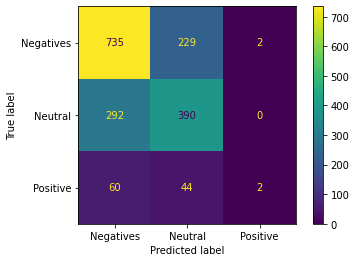

In [40]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
print(cm_dsp.plot())

In [41]:
%%time

#predicting 
y_pred = svm_model.predict(X_test.values.astype('U'))

model_score = svm_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6425313568985177
Model Score: 64.25%

Accuracy: 0.6425313568985177
Accuracy: 64.25%

F1-score: 0.6220321019060553
F1-score: 62.20%

CPU times and Wall time: 
CPU times: user 2.69 s, sys: 6.26 ms, total: 2.7 s
Wall time: 2.69 s


In [42]:
# Save to file / directory
joblib_file = "models/SVM_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(svm_model, joblib_file)

['models/SVM_model_score_64.25.pkl']

## 4.2 RANDOM FOREST

In [43]:
# Initialize a vectorization and modelling pipeline
rf_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', RandomForestClassifier()),
 ])

In [44]:
# RANDOM FOREST Algorithm training X_train, X_test, y_train, y_test
rf_model = rf_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
rf_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [45]:
y_pred = rf_model.predict(X_test.values.astype('U'))
rf_model.classes_

array([-1,  0,  1])

In [46]:
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
print(cm)

[[749 217   0]
 [301 379   2]
 [ 63  36   7]]


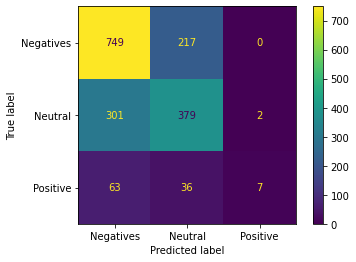

In [47]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [48]:
%%time

#predicting 
y_pred = rf_model.predict(X_test.values.astype('U'))

model_score = rf_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6470923603192702
Model Score: 64.71%

Accuracy: 0.6470923603192702
Accuracy: 64.71%

F1-score: 0.628487095359582
F1-score: 62.85%

CPU times and Wall time: 
CPU times: user 383 ms, sys: 2.99 ms, total: 386 ms
Wall time: 390 ms


In [49]:
# Save to file / directory
joblib_file = "models/Randomforest_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(rf_model, joblib_file)

['models/Randomforest_model_score_64.71.pkl']

# 4.3 DECISION TREE CLASSIFIER

In [50]:
# Initialize a vectorization and modelling pipeline
dt_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', DecisionTreeClassifier()),
 ])

In [51]:
# Algorithm training X_train, X_test, y_train, y_test
dt_model = dt_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
dt_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier())])

In [52]:
y_pred = dt_model.predict(X_test.values.astype('U'))
dt_model.classes_

array([-1,  0,  1])

In [53]:
cm = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)
print(cm)

[[605 318  43]
 [285 365  32]
 [ 56  40  10]]


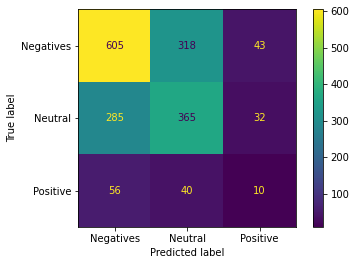

In [54]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [55]:
%%time

#predicting 
y_pred = dt_model.predict(X_test.values.astype('U'))

model_score = dt_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.5587229190421893
Model Score: 55.87%

Accuracy: 0.5587229190421893
Accuracy: 55.87%

F1-score: 0.5568852239287538
F1-score: 55.69%

CPU times and Wall time: 
CPU times: user 82.3 ms, sys: 1.97 ms, total: 84.3 ms
Wall time: 83.8 ms


In [56]:
# Save to file / directory
joblib_file = "models/DecisionTreeClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(dt_model, joblib_file)

['models/DecisionTreeClassifier_model_score_55.87.pkl']

# 4.4 KNEIGHBORS CLASSIFIER

In [57]:
# Initialize a vectorization and modelling pipeline
kn_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', KNeighborsClassifier()), 
 ])

In [58]:
# Algorithm training X_train, X_test, y_train, y_test
kn_model = kn_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
kn_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])

In [59]:
y_pred = kn_model.predict(X_test.values.astype('U'))
kn_model.classes_

array([-1,  0,  1])

In [60]:
cm = confusion_matrix(y_test, y_pred, labels=kn_model.classes_)
print(cm)

[[623 335   8]
 [281 398   3]
 [ 54  49   3]]


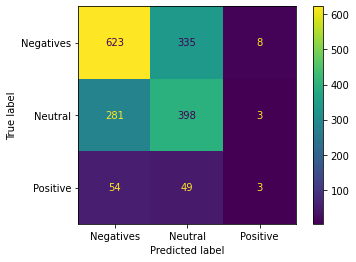

In [61]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [62]:
%%time

#predicting 
y_pred = kn_model.predict(X_test.values.astype('U'))

model_score = kn_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.5838084378563284
Model Score: 58.38%

Accuracy: 0.5838084378563284
Accuracy: 58.38%

F1-score: 0.5710972886207012
F1-score: 57.11%

CPU times and Wall time: 
CPU times: user 9.76 s, sys: 19.6 ms, total: 9.78 s
Wall time: 6.51 s


In [63]:
# Save to file / directory
joblib_file = "models/KNeighborsClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(kn_model, joblib_file)

['models/KNeighborsClassifier_model_score_58.38.pkl']

# 4.5 LOGISTIC REGRESSION 

In [64]:
# Initialize a vectorization and modelling pipeline
lr_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,5))),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression()), 
 ])

In [65]:
# Algorithm training X_train, X_test, y_train, y_test
lr_model = lr_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
lr_model

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 5))),
                ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])

In [66]:
y_pred = lr_model.predict(X_test.values.astype('U'))
lr_model.classes_

array([-1,  0,  1])

In [67]:
cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)
print(cm)

[[787 179   0]
 [308 373   1]
 [ 71  35   0]]


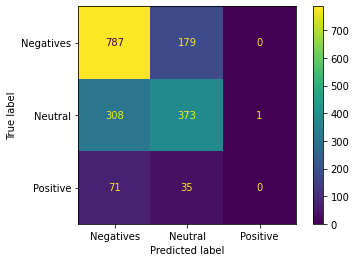

In [68]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [69]:
%%time

#predicting 
y_pred = lr_model.predict(X_test.values.astype('U'))

model_score = lr_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.661345496009122
Model Score: 66.13%

Accuracy: 0.661345496009122
Accuracy: 66.13%

F1-score: 0.6351745551537383
F1-score: 63.52%

CPU times and Wall time: 
CPU times: user 237 ms, sys: 1.94 ms, total: 239 ms
Wall time: 240 ms


In [70]:
# Save to file / directory
joblib_file = "models/Logistic regression_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(kn_model, joblib_file)

['models/Logistic regression_model_score_66.13.pkl']

# 4.6 GRADIENT BOOSTING CLASSIFIER

In [71]:
# Initialize a vectorization and modelling pipeline
gd_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', GradientBoostingClassifier()), 
 ])

In [72]:
# Algorithm training X_train, X_test, y_train, y_test
gd_model = gd_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
gd_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier())])

In [73]:
y_pred = gd_model.predict(X_test.values.astype('U'))
gd_model.classes_

array([-1,  0,  1])

In [74]:
cm = confusion_matrix(y_test, y_pred, labels=gd_model.classes_)
print(cm)

[[777 187   2]
 [353 325   4]
 [ 65  35   6]]


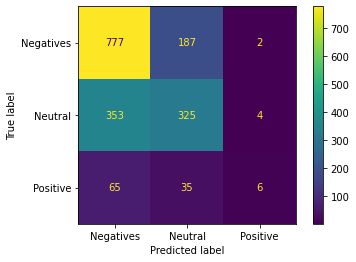

In [75]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [76]:
%%time

#predicting 
y_pred = gd_model.predict(X_test.values.astype('U'))

model_score = gd_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6316989737742303
Model Score: 63.17%

Accuracy: 0.6316989737742303
Accuracy: 63.17%

F1-score: 0.6078341776489709
F1-score: 60.78%

CPU times and Wall time: 
CPU times: user 133 ms, sys: 574 µs, total: 134 ms
Wall time: 213 ms


In [77]:
# Save to file / directory
joblib_file = "models/GradientBoostingClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(gd_model, joblib_file)

['models/GradientBoostingClassifier_model_score_63.17.pkl']

# 4.7 MULTINOMIALNB

In [78]:
# Initialize a vectorization and modelling pipeline
mnb_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()), 
 ])

In [79]:
# Algorithm training X_train, X_test, y_train, y_test
mnb_model = mnb_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
mnb_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [80]:
y_pred = mnb_model.predict(X_test.values.astype('U'))
mnb_model.classes_

array([-1,  0,  1])

In [81]:
cm = confusion_matrix(y_test, y_pred, labels=mnb_model.classes_)
print(cm)

[[847 119   0]
 [401 281   0]
 [ 83  23   0]]


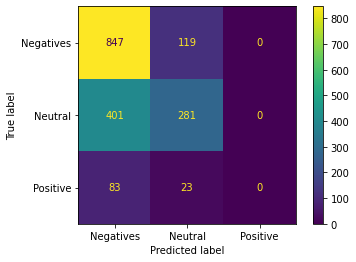

In [82]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [83]:
%%time

#predicting 
y_pred = mnb_model.predict(X_test.values.astype('U'))

model_score = mnb_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6431014823261118
Model Score: 64.31%

Accuracy: 0.6431014823261118
Accuracy: 64.31%

F1-score: 0.6039182313831132
F1-score: 60.39%

CPU times and Wall time: 
CPU times: user 82.8 ms, sys: 1.15 ms, total: 84 ms
Wall time: 82 ms


In [84]:
# Save to file / directory
joblib_file = "models/MultinomialNB_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(mnb_model, joblib_file)

['models/MultinomialNB_model_score_64.31.pkl']

# 4.8 XGBoost classifier

In [85]:
xgb_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', xgb.XGBClassifier(learning_rate=0.001,
                            max_depth = 1, 
                           n_estimators = 100,)),
 ])

In [86]:
Xg_train = X_train.values.astype('U')
Xg_test = X_test.values.astype('U')
yg_train = y_train
yg_test= y_test

In [87]:
le = LabelEncoder()
yg_train = le.fit_transform(yg_train)

In [88]:
xgbmodel = xgb_pipeline.fit(Xg_train, yg_train)

In [143]:
yg_pred = xgbmodel.predict(Xg_test)
xgbmodel.classes_

array([0, 1, 2])

In [90]:
cm = confusion_matrix(yg_test, yg_pred, labels=xgbmodel.classes_)
print(cm)


[[682   0   0]
 [106   0   0]
 [  0   0   0]]


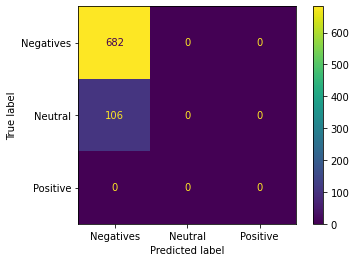

In [91]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()
plt.show()

In [92]:
%%time
model_score = xgbmodel.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(yg_test, yg_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(yg_test, yg_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.3888255416191562
Model Score: 38.88%

Accuracy: 0.3888255416191562
Accuracy: 38.88%

F1-score: 0.21771676468330423
F1-score: 21.77%

CPU times and Wall time: 
CPU times: user 96.6 ms, sys: 0 ns, total: 96.6 ms
Wall time: 97.8 ms


In [93]:
# Save to file / directory
joblib_file = "models/XGB_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(xgbmodel, joblib_file)

['models/XGB_model_score_38.88.pkl']

# 4.9 LightGBM classifier

In [94]:
lgbm_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', LGBMClassifier()),  
     ])

In [95]:
# Algorithm training X_train, X_test, y_train, y_test
lgbm_model = lgbm_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
lgbm_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LGBMClassifier())])

In [96]:
y_pred = lgbm_model.predict(X_test.values.astype('U'))
lgbm_model.classes_

array([-1,  0,  1])

In [97]:
cm = confusion_matrix(y_test, y_pred, labels=lgbm_model.classes_)
print(cm)

[[709 250   7]
 [268 410   4]
 [ 58  42   6]]


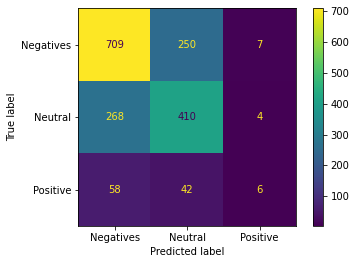

In [98]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [99]:
%%time

#predicting 
y_pred = lgbm_model.predict(X_test.values.astype('U'))

model_score = lgbm_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6413911060433295
Model Score: 64.14%

Accuracy: 0.6413911060433295
Accuracy: 64.14%

F1-score: 0.6265497902287547
F1-score: 62.65%

CPU times and Wall time: 
CPU times: user 257 ms, sys: 1.1 ms, total: 258 ms
Wall time: 159 ms


In [100]:
# Save to file / directory
joblib_file = "models/LGBMClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(lgbm_model, joblib_file)

['models/LGBMClassifier_model_score_64.14.pkl']

# 4.10 CatBoost classifier

In [101]:
ctb_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', CatBoostClassifier()), 
 ])

In [102]:
# Algorithm training X_train, X_test, y_train, y_test
ctb_model = ctb_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('int64'))
ctb_model

Learning rate set to 0.087391
0:	learn: 1.0682164	total: 374ms	remaining: 6m 13s
1:	learn: 1.0420328	total: 656ms	remaining: 5m 27s
2:	learn: 1.0198247	total: 917ms	remaining: 5m 4s
3:	learn: 1.0011174	total: 1.19s	remaining: 4m 56s
4:	learn: 0.9844740	total: 1.45s	remaining: 4m 47s
5:	learn: 0.9696109	total: 1.71s	remaining: 4m 42s
6:	learn: 0.9568077	total: 1.98s	remaining: 4m 40s
7:	learn: 0.9455714	total: 2.25s	remaining: 4m 38s
8:	learn: 0.9356233	total: 2.51s	remaining: 4m 36s
9:	learn: 0.9253067	total: 2.78s	remaining: 4m 34s
10:	learn: 0.9161551	total: 3.05s	remaining: 4m 34s
11:	learn: 0.9081726	total: 3.32s	remaining: 4m 33s
12:	learn: 0.9010100	total: 3.57s	remaining: 4m 31s
13:	learn: 0.8951394	total: 3.83s	remaining: 4m 30s
14:	learn: 0.8901943	total: 4.09s	remaining: 4m 28s
15:	learn: 0.8842832	total: 4.36s	remaining: 4m 28s
16:	learn: 0.8800857	total: 4.77s	remaining: 4m 35s
17:	learn: 0.8761108	total: 5.23s	remaining: 4m 45s
18:	learn: 0.8726391	total: 5.67s	remaining: 

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7ff8812a9820>)])

In [103]:
y_pred = ctb_model.predict(X_test.values.astype('U'))
ctb_model.classes_

array([-1,  0,  1])

In [104]:
cm = confusion_matrix(y_test, y_pred, labels=ctb_model.classes_)
print(cm)

[[747 218   1]
 [306 376   0]
 [ 60  40   6]]


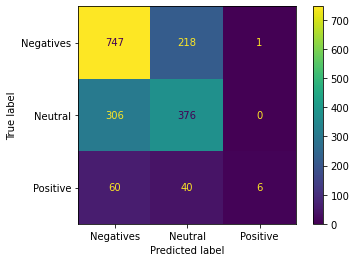

In [105]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive'])
cm_dsp.plot()

In [106]:
%%time

#predicting 
y_pred = ctb_model.predict(X_test.values.astype('U'))

model_score = ctb_model.score(X_test.values.astype('U'), y_test.values.astype('int64'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6436716077537058
Model Score: 64.37%

Accuracy: 0.6436716077537058
Accuracy: 64.37%

F1-score: 0.6243744247800715
F1-score: 62.44%

CPU times and Wall time: 
CPU times: user 270 ms, sys: 19.1 ms, total: 290 ms
Wall time: 206 ms


In [107]:
# Save to file / directory
joblib_file = "models/CatBoostClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(ctb_model, joblib_file)

['models/CatBoostClassifier_model_score_64.37.pkl']